# Quiz One

## Instructions:
Solve all problems in python to the best of your ability. You are welcome to use Excel in order to check your answers, but you must submit a python notebook exported as an html file to receive full credit. Furthermore, feel free to collaborate with your fellow classmates. You need to turn in your own copy of the notebook. All figures must contain your name in the title in order to receive full credit. 

### Due Date: Wednesday, February 15 2023 at 11.59pm

# Urbaczewski's Ski Boots<a id=1></a>

We are revisiting a transshipment problem similar to one that we solved in the second class of Week 2. In this problem, Elmore's Ski Boots is the manufacturer of the finest ski boots available. There are three plants that manufacture the boots, two distribution centers, and five warehouses. We need to ship the boots to the warehouses at a minimum cost satisfying the constraints outlined in the spreadsheet. Namely, each plant can only produce so much product, the amount of boots passing through the distribution centers has to remain constant (in has to equal out), and each warehouse has a minimum amount that they need in order to satisfy demand. The data are given in the Excel file `quiz-1.xlsx`.

## Solve the following problems. 
1. What is the minimum cost to ship these boots from our plants to the warehouses while satisfying all of our constraints? 
2. What are the final values of the decision variables?
3. Is there any slack in the system? If so, what is the amount/route that shows slack?
4. Suppose management tells us that the per unit shipping cost from Plant P3 to Distribution Center D1 is going to change to \$.60. How do your answers to 1. and 2. change? 
5. Show the values of the decision variables as barcharts using `seaborn`. Create a separate plot for Plants to Distribution Centers (colored by DCs) and another for DCs to Warehouses (colored by WHs).
6. Create a sequence of shipping costs (P3 to D1) from 0.5 to 0.7 in one cent increments (21 unique values). 

    a. Make a plot showing how the overall shipping costs change as a function of this sequence.
    
    b. Make two plots showing: (1) the amount of boots shipped between Plant P3 and the two distribution centers and (2) the amount of boots shipped between each distribution center and the five warehouses. The lines be shown using different colors. 
    
7. Finally, let's investigate how changing the demand on the third warehouse changes the final value of the objective function. Create a sequence of demands from 4700 to 7200 by 100 units. Plots those demands on the x axis and the final minimum cost on the y.

##### [Back to Top](#Top)

### Import Modules<a id=2></a>

In [1]:
import pandas as pd 
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

### Read and convert data

In [2]:
xlsx_file = pd.ExcelFile('quiz-1-excel.xlsx')
xlsx_file.sheet_names

["Urbaczewski's Ski Boots", 'Coef_1', 'Coef_2', 'RHS']

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Problem 1
1. What is the minimum cost to ship these boots from our plants to the warehouses while satisfying all of our constraints? 

In [4]:
main_page = pd.read_excel("quiz-1-excel.xlsx", sheet_name="Urbaczewski's Ski Boots")
coef_1_page = pd.read_excel("quiz-1-excel.xlsx", sheet_name="Coef_1")
coef_2_page = pd.read_excel("quiz-1-excel.xlsx", sheet_name = "Coef_2")
rhs_page = pd.read_excel("quiz-1-excel.xlsx", sheet_name="RHS")

In [5]:
cost_PtoD = pd.read_excel(xlsx_file, sheet_name = "Coef_1", index_col = 0, usecols = [0,1,2], nrows = 4)
cost_PtoD

,D1,D2
(From) Plant,,
P1,0.50,0.60
P2,0.65,0.65
P3,0.63,0.78


In [6]:
cost_DtoW = pd.read_excel(xlsx_file, sheet_name="Coef_2", index_col=0)
cost_DtoW

,W1,W2,W3,W4,W5
(From) DC,,,,,
D1,0.5,0.4,0.3,0.5,0.72
D2,0.7,0.6,0.2,0.5,0.55


In [7]:
capacity = pd.read_excel(xlsx_file, sheet_name = "RHS", index_col = 0, usecols = [0,1], nrows = 3)
capacity

,Capacity
P1,10000
P2,11000
P3,10500


In [8]:
requirement = pd.read_excel(xlsx_file, sheet_name="RHS", index_col=0, usecols=[2, 3], nrows=6)
requirement

,Requirement
W1,5000
W2,7500
W3,6000
W4,5500
W5,6250


In [9]:
model = pe.ConcreteModel()

In [10]:
DV_indexes_PtoD = ['D1', 'D2']
model.P1 = pe.Var(DV_indexes_PtoD, domain = pe.NonNegativeReals)
model.P2 = pe.Var(DV_indexes_PtoD, domain = pe.NonNegativeReals)
model.P3 = pe.Var(DV_indexes_PtoD, domain = pe.NonNegativeReals)

In [11]:
DV_indexes_DtoW = ['W1', 'W2', 'W3', 'W4', 'W5']
model.D1 = pe.Var(DV_indexes_DtoW, domain=pe.NonNegativeReals)
model.D2 = pe.Var(DV_indexes_DtoW, domain=pe.NonNegativeReals)
model.pprint()

5 Set Declarations
    D1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'W1', 'W2', 'W3', 'W4', 'W5'}
    D2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'W1', 'W2', 'W3', 'W4', 'W5'}
    P1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    P2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    P3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}

5 Var Declarations
    D1 : Size=5, Index=D1_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         W1 :     0 :  None :  None : False :  True : NonNegativeReals
 

In [12]:
model.obj = pe.Objective(expr = sum([cost_PtoD.loc['P1', index]*model.P1[index] for index in DV_indexes_PtoD] +
                         [cost_PtoD.loc['P2', index]*model.P2[index] for index in DV_indexes_PtoD] +
                         [cost_PtoD.loc['P3', index]*model.P3[index] for index in DV_indexes_PtoD] +
                         [cost_DtoW.loc['D1', index] * model.D1[index] for index in DV_indexes_DtoW] +
                         [cost_DtoW.loc['D2', index] * model.D2[index] for index in DV_indexes_DtoW]),
                         sense = pe.minimize)

In [13]:
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 0.5*P1[D1] + 0.6*P1[D2] + 0.65*P2[D1] + 0.65*P2[D2] + 0.63*P3[D1] + 0.78*P3[D2] + 0.5*D1[W1] + 0.4*D1[W2] + 0.3*D1[W3] + 0.5*D1[W4] + 0.72*D1[W5] + 0.7*D2[W1] + 0.6*D2[W2] + 0.2*D2[W3] + 0.5*D2[W4] + 0.55*D2[W5]


In [14]:
#Capacity Constraints
model.con_P1 = pe.Constraint(expr = sum(model.P1[index] for index in DV_indexes_PtoD) 
                              <= capacity.loc['P1','Capacity'])
model.con_P2 = pe.Constraint(expr = sum(model.P2[index] for index in DV_indexes_PtoD)
                              <= capacity.loc['P2','Capacity'])
model.con_P3 = pe.Constraint(expr = sum(model.P3[index] for index in DV_indexes_PtoD)
                              <= capacity.loc['P3','Capacity'])  
#Requirement Constraints
model.con_W1 = pe.Constraint(expr = model.D1['W1'] + model.D2['W1'] 
                             >= requirement.loc['W1','Requirement'])
model.con_W2 = pe.Constraint(expr = model.D1['W2'] + model.D2['W2'] 
                             >= requirement.loc['W2','Requirement'])
model.con_W3 = pe.Constraint(expr = model.D1['W3'] + model.D2['W3'] 
                             >= requirement.loc['W3','Requirement'])
model.con_W4 = pe.Constraint(expr = model.D1['W4'] + model.D2['W4'] 
                             >= requirement.loc['W4','Requirement'])
model.con_W5 = pe.Constraint(expr = model.D1['W5'] + model.D2['W5'] 
                             >= requirement.loc['W5','Requirement'])
#Matching Constraints
model.con_D1 = pe.Constraint(expr = model.D1['W1'] + model.D1['W2'] + model.D1['W3'] + model.D1['W4'] + model.D1['W5'] 
                              == model.P1['D1'] + model.P2['D1'] + model.P3['D1'])
model.con_D2 = pe.Constraint(expr = model.D2['W1'] + model.D2['W2'] + model.D2['W3'] + model.D2['W4'] + model.D2['W5'] 
                              == model.P1['D2'] + model.P2['D2'] + model.P3['D2'])

In [15]:
model.con_P1.pprint()

con_P1 : Size=1, Index=None, Active=True
    Key  : Lower : Body            : Upper   : Active
    None :  -Inf : P1[D1] + P1[D2] : 10000.0 :   True


In [16]:
opt = pe.SolverFactory('glpk')
result = opt.solve(model)
print(result.solver.status, result.solver.termination_condition)

ok optimal


In [17]:
model.display()

Model unknown

  Variables:
    P1 : Size=2, Index=P1_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
         D1 :     0 : 10000.0 :  None : False : False : NonNegativeReals
         D2 :     0 :     0.0 :  None : False : False : NonNegativeReals
    P2 : Size=2, Index=P2_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
         D1 :     0 :     0.0 :  None : False : False : NonNegativeReals
         D2 :     0 : 11000.0 :  None : False : False : NonNegativeReals
    P3 : Size=2, Index=P3_index
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
         D1 :     0 : 9250.0 :  None : False : False : NonNegativeReals
         D2 :     0 :    0.0 :  None : False : False : NonNegativeReals
    D1 : Size=5, Index=D1_index
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
         W1 :     0 : 5000.0 :  None : False : False : NonNegativeReals
         W2 :     0 : 7500.0 :  None : False : False : NonNegativeReals
         W3 : 

In [18]:
obj_val = model.obj.expr()
printmd(f'optimal capacity objective value minimum cost = ${obj_val:.2f}')

optimal capacity objective value minimum cost = $30990.00

#### Problem 2
2. What are the final values of the decision variables?

In [19]:
df_p = pd.DataFrame()
df_d = pd.DataFrame()
for dv in model.component_objects(pe.Var):
    if dv.name.startswith('P'):
        values = {f'{subvar}': dv[subvar].value for subvar in dv}
        df_p = pd.concat([df_p, pd.DataFrame(values, index=[dv.name])])
    elif dv.name.startswith('D'):
        values = {f'{subvar}': dv[subvar].value for subvar in dv}
        df_d = pd.concat([df_d, pd.DataFrame(values, index=[dv.name])])

print(df_p)
print(df_d)

         D1       D2
P1  10000.0      0.0
P2      0.0  11000.0
P3   9250.0      0.0
        W1      W2      W3      W4      W5
D1  5000.0  7500.0  1250.0  5500.0     0.0
D2     0.0     0.0  4750.0     0.0  6250.0


#### Problem 3
3. Is there any slack in the system? If so, what is the amount/route that shows slack?

In [20]:
print(f'P1 Slack = {model.con_P1.slack()}')
print(f'P2 Slack = {model.con_P2.slack()}')
print(f'P3 Slack = {model.con_P3.slack()}')
print(f'D1 Slack = {model.con_D1.slack()}')
print(f'D2 Slack = {model.con_D2.slack()}')
print(f'W1 Slack = {model.con_W1.slack()}')
print(f'W2 Slack = {model.con_W2.slack()}')
print(f'W3 Slack = {model.con_W3.slack()}')
print(f'W4 Slack = {model.con_W4.slack()}')
print(f'W5 Slack = {model.con_W5.slack()}')
printmd(f'The slack in the system comes from Plant 3, it produces {model.con_P3.slack():.0f} units less than is possible.')

P1 Slack = 0.0
P2 Slack = 0.0
P3 Slack = 1250.0
D1 Slack = 0.0
D2 Slack = 0.0
W1 Slack = 0.0
W2 Slack = 0.0
W3 Slack = 0.0
W4 Slack = 0.0
W5 Slack = 0.0


The slack in the system comes from Plant 3, it produces 1250 units less than is possible.

#### Problem 4
4. Suppose management tells us that the per unit shipping cost from Plant P3 to Distribution Center D1 is going to change to \$.60. How do your answers to 1. and 2. change? 

In [21]:
def run_model():
    model = pe.ConcreteModel()

    DV_indexes_PtoD = ['D1', 'D2']
    model.P1 = pe.Var(DV_indexes_PtoD, domain = pe.NonNegativeReals)
    model.P2 = pe.Var(DV_indexes_PtoD, domain = pe.NonNegativeReals)
    model.P3 = pe.Var(DV_indexes_PtoD, domain = pe.NonNegativeReals)

    DV_indexes_DtoW = ['W1', 'W2', 'W3', 'W4', 'W5']
    model.D1 = pe.Var(DV_indexes_DtoW, domain=pe.NonNegativeReals)
    model.D2 = pe.Var(DV_indexes_DtoW, domain=pe.NonNegativeReals)

    model.obj = pe.Objective(expr = sum([cost_PtoD.loc['P1', index]*model.P1[index] for index in DV_indexes_PtoD] +
                         [cost_PtoD.loc['P2', index]*model.P2[index] for index in DV_indexes_PtoD] +
                         [cost_PtoD.loc['P3', index]*model.P3[index] for index in DV_indexes_PtoD] +
                         [cost_DtoW.loc['D1', index] * model.D1[index] for index in DV_indexes_DtoW] +
                         [cost_DtoW.loc['D2', index] * model.D2[index] for index in DV_indexes_DtoW]),
                         sense = pe.minimize)

    #Capacity Constraints
    model.con_P1 = pe.Constraint(expr = sum(model.P1[index] for index in DV_indexes_PtoD) 
                              <= capacity.loc['P1','Capacity'])
    model.con_P2 = pe.Constraint(expr = sum(model.P2[index] for index in DV_indexes_PtoD)
                              <= capacity.loc['P2','Capacity'])
    model.con_P3 = pe.Constraint(expr = sum(model.P3[index] for index in DV_indexes_PtoD)
                              <= capacity.loc['P3','Capacity'])  
    #Requirement Constraints
    model.con_W1 = pe.Constraint(expr = model.D1['W1'] + model.D2['W1'] 
                             >= requirement.loc['W1','Requirement'])
    model.con_W2 = pe.Constraint(expr = model.D1['W2'] + model.D2['W2'] 
                             >= requirement.loc['W2','Requirement'])
    model.con_W3 = pe.Constraint(expr = model.D1['W3'] + model.D2['W3'] 
                             >= requirement.loc['W3','Requirement'])
    model.con_W4 = pe.Constraint(expr = model.D1['W4'] + model.D2['W4'] 
                             >= requirement.loc['W4','Requirement'])
    model.con_W5 = pe.Constraint(expr = model.D1['W5'] + model.D2['W5'] 
                             >= requirement.loc['W5','Requirement'])
    #Matching Constraints
    model.con_D1 = pe.Constraint(expr = model.D1['W1'] + model.D1['W2'] + model.D1['W3'] + model.D1['W4'] + model.D1['W5'] 
                              == model.P1['D1'] + model.P2['D1'] + model.P3['D1'])
    model.con_D2 = pe.Constraint(expr = model.D2['W1'] + model.D2['W2'] + model.D2['W3'] + model.D2['W4'] + model.D2['W5'] 
                              == model.P1['D2'] + model.P2['D2'] + model.P3['D2'])
    opt = pe.SolverFactory('glpk')
    #opt.solve(model,tee=True) 
    success=opt.solve(model)

    return model

In [22]:
cost_PtoD_orig = cost_PtoD.copy()
cost_PtoD_orig

,D1,D2
(From) Plant,,
P1,0.50,0.60
P2,0.65,0.65
P3,0.63,0.78


In [23]:
cost_PtoD = cost_PtoD_orig.copy() #reset to original
cost_PtoD.loc['P3','D1'] = cost_PtoD.loc['P3','D1'] - .03
cost_PtoD

,D1,D2
(From) Plant,,
P1,0.50,0.60
P2,0.65,0.65
P3,0.60,0.78


In [24]:
model = run_model()
obj_val = model.obj.expr()
printmd(f'New optimal objective value minimum cost = ${obj_val:.2f}')

New optimal objective value minimum cost = $30712.50

#### Problem 5
5. Show the values of the decision variables as barcharts using `seaborn`. Create a separate plot for Plants to Distribution Centers (colored by DCs) and another for DCs to Warehouses (colored by WHs).

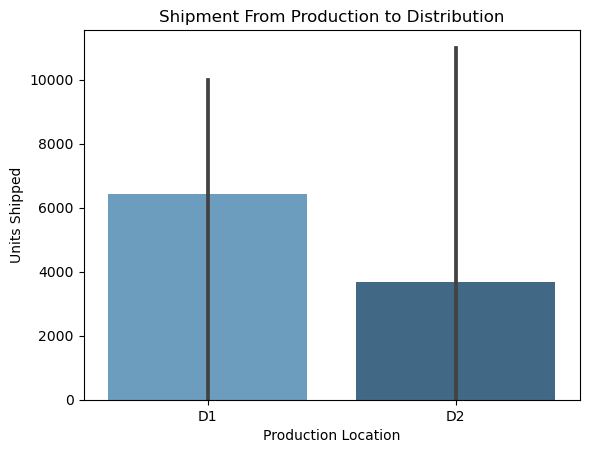

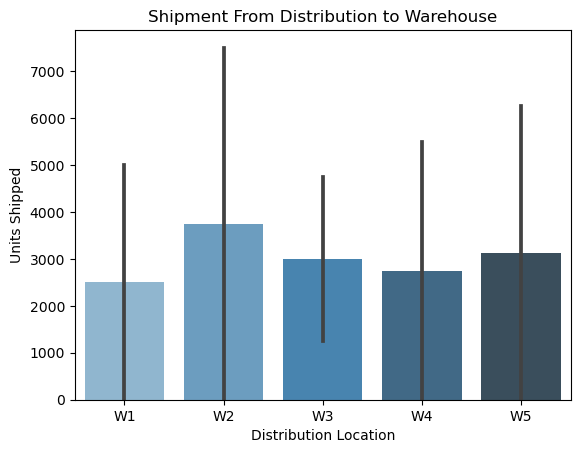

In [25]:
sns.barplot(data=df_p, palette="Blues_d")
plt.title('Shipment From Production to Distribution')
plt.xlabel('Production Location')
plt.ylabel('Units Shipped')
plt.show()

sns.barplot(data=df_d, palette="Blues_d")
plt.title('Shipment From Distribution to Warehouse')
plt.xlabel('Distribution Location')
plt.ylabel('Units Shipped')
plt.show()


#### Problem 6a
6. Create a sequence of shipping costs (P3 to D1) from 0.5 to 0.7 in one cent increments (21 unique values). 

    a. Make a plot showing how the overall shipping costs change as a function of this sequence.

In [26]:
shipping_P3D1 = [(i + 50)/100 for i in list(range(0, 21))]

In [27]:
obj_list_P3D1 = []
for val in shipping_P3D1:
    cost_PtoD.loc['P3','D1'] = val
    model = run_model()
    obj_list_P3D1.append(model.obj.expr())

In [28]:
obj_df_P3D1 = pd.DataFrame(obj_list_P3D1, 
                         index = shipping_P3D1, 
                         columns = ['cost'])

In [29]:
zip_list = list(zip(shipping_P3D1, obj_list_P3D1))

In [30]:
df = pd.DataFrame(zip_list, columns = ['P3 to D1', 'Cost'])

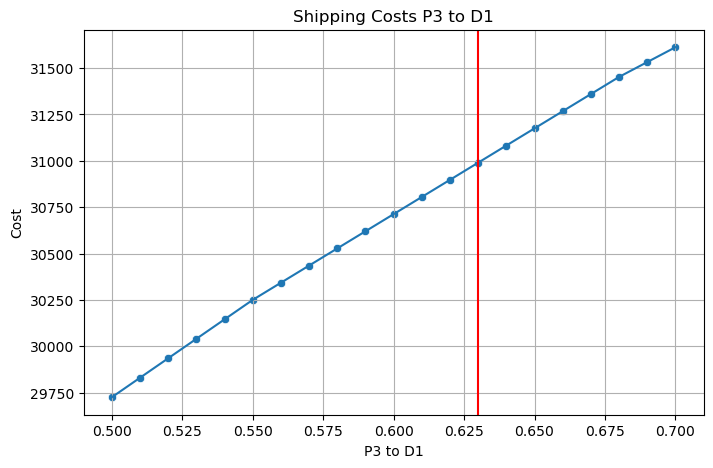

In [31]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = 'P3 to D1', y = 'Cost', data = df).set(title='Shipping Costs P3 to D1')
sns.lineplot(x = 'P3 to D1', y = 'Cost', data = df)
plt.grid()
plt.axvline(x = .63, color = "red")
plt.show()

#### Problem 6b
   b. Make two plots showing: (1) the amount of boots shipped between Plant P3 and the two distribution centers and (2) the amount of boots shipped between each distribution center and the five warehouses. The lines should be shown using different colors. 

In [32]:
DV_list_P3D1=[]
for val in shipping_P3D1:
    DV_curr_list_P3D1 = []
    cost_PtoD.loc['P3','D1'] = val
    model = run_model()
    for DV in model.component_objects(pe.Var):
        for c in DV:
            DV_curr_list_P3D1.append(DV[c].value)
    DV_list_P3D1.append(DV_curr_list_P3D1)

In [33]:

DV_col_names = ['P1,D1', 'P1,D2', 'P2,D1', 'P2,D2', 'P3,D1', 'P3,D2', 'D1,W1', 'D1,W2', 'D1,W3', 'D1,W4', 'D1,W5', 'D2,W1', 'D2,W2', 'D2,W3', 'D2,W4', 'D2,W5']

df = pd.DataFrame(DV_list_P3D1, columns=DV_col_names)


In [34]:
split_index = DV_col_names.index('P3,D2')
dfPD = df.iloc[:, :split_index+1]
dfDW = df.iloc[:, split_index+1:]

In [35]:
dfPD.loc[:, 'P3 to D1 Cost'] = shipping_P3D1
dfDW.loc[:, 'P3 to D1 Cost'] = shipping_P3D1

/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/ipykernel_89464/808809182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPD.loc[:, 'P3 to D1 Cost'] = shipping_P3D1
/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/ipykernel_89464/808809182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDW.loc[:, 'P3 to D1 Cost'] = shipping_P3D1


In [36]:
dfPDMelt = pd.melt(dfPD, 'P3 to D1 Cost')
dfDWMelt = pd.melt(dfDW, 'P3 to D1 Cost')

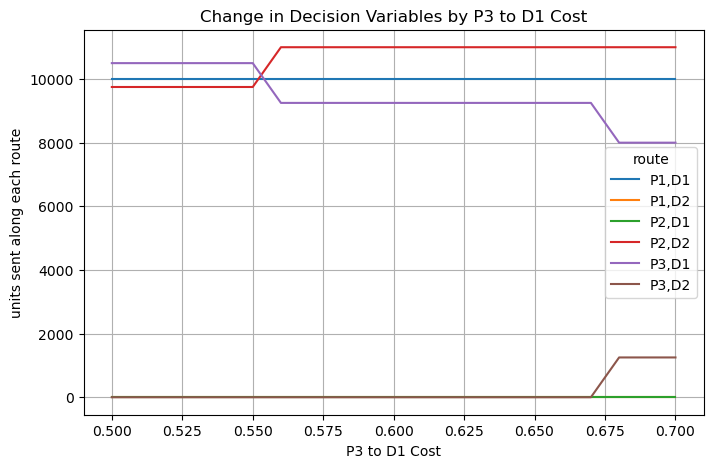

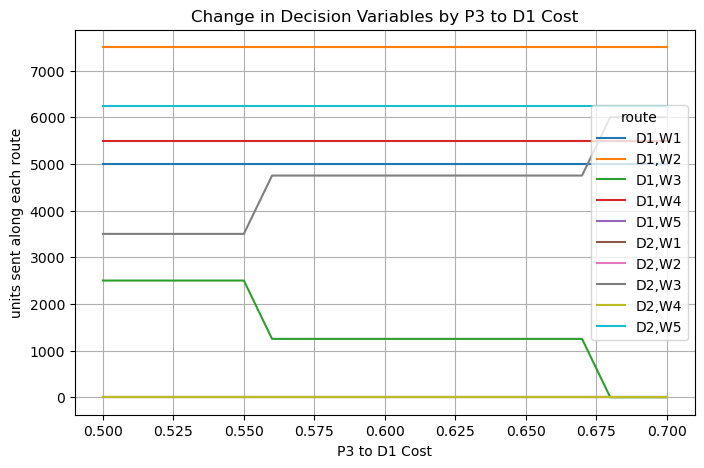

In [37]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'P3 to D1 Cost', y = 'value', hue = 'variable',
             data = dfPDMelt)
plt.grid()
plt.title('Change in Decision Variables by P3 to D1 Cost')
plt.ylabel('units sent along each route')
plt.legend(title = "route")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(x = 'P3 to D1 Cost', y = 'value', hue = 'variable',
             data = dfDWMelt)
plt.grid()
plt.title('Change in Decision Variables by P3 to D1 Cost')
plt.ylabel('units sent along each route')
plt.legend(title = "route")
plt.show()

#### Problem 7
7. Finally, let's investigate how changing the demand on the third warehouse changes the final value of the objective function. Create a sequence of demands from 4700 to 7200 by 100 units. Plots those demands on the x axis and the final minimum cost on the y.

In [38]:
demand_W3 = list(range(4700, 7200, 100))

In [39]:
obj_list_W3 = []
for val in demand_W3:
    cost_DtoW.loc['W3'] = val
    model = run_model()
    obj_list_W3.append(model.obj.expr())

In [40]:
obj_df_W3 = pd.DataFrame(obj_list_W3, 
                         index = demand_W3, 
                         columns = ['cost'])

In [41]:
zip_listW3 = list(zip(demand_W3, obj_list_W3))

In [42]:
dfW3 = pd.DataFrame(zip_listW3, columns = ['W3', 'Cost'])

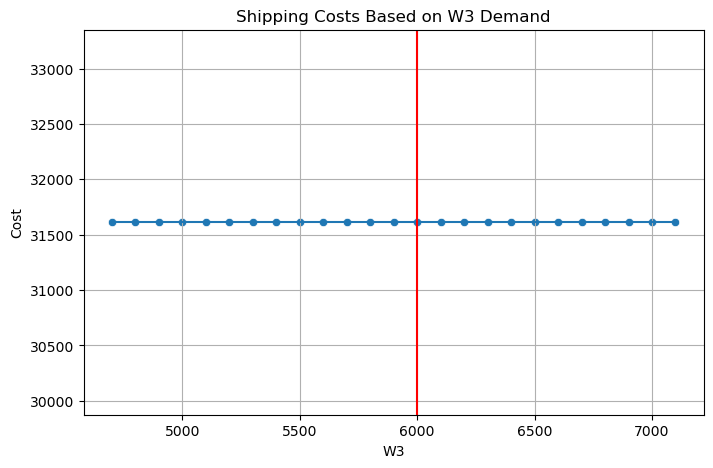

In [43]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = 'W3', y = 'Cost', data = dfW3).set(title='Shipping Costs Based on W3 Demand')
sns.lineplot(x = 'W3', y = 'Cost', data = dfW3)
plt.grid()
plt.axvline(x = 6000, color = "red")
plt.show()